### Combine predictions of 3 RNN models
to evaluate whether a voltage rise will occur in next step
- **Model1** : Compute power flow and get voltage rise based on Predicted $\tilde{X(k)}$ and $\tilde{Y(k)}$ 
- **Model2** : Predict binary voltage rise i.e. 0 or 1
- **Model3** : Predict the numerical value of the voltage rise based on inputs 


V_rise threshold= 1.025

The user with the help of  ``paramUser``  get to choose the combination or the unique model to use.

Section 2.1 of [VRiseControlBlockScheme](../Docs/VRiseControlBlockScheme.pdf) describes the principle of functionning of the combined prediction. 

---

#### Import modules to be used

In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling   
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib
import ipyparallel as ipp


#### Import my own modules

In [2]:
# import psutil
function_folder = '../Modules/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
import checker
import oriClass as oriCs
from oriVariables import (simResult_folder,
                          defAuth_hvBus_vRiseMax,
                          default_hv_voltage,
                          defAuth_hvBus_vRiseMin, 
                          ctrld_HvProd_name,
                          h_start_end,
                          testSet_end_M1,
                          valSet_start_M2, 
                          valSet_start_M1,
                          Δt,  
                          pd_Δt,  
                          lowerNet_file_loc, 
                          upperNet_file_loc
                          )

#### Import Networks


In [3]:
lowerNet=pp.from_pickle(lowerNet_file_loc)
upperNet=pp.from_pickle(upperNet_file_loc)


# Init an object of InitNetworks
networks = oriCs.InitNetworks(upperNet, lowerNet)

# To use later in functions 
sum_max_main_network = networks.get_upperNet_sum_max_lvProdLoad()

# Extract the total of BT prod and Load on St Laurent the upper network
sum_max_p_mw_StLaurent_prodBT = sum_max_main_network[0]
sum_max_p_mw_StLaurent_load = sum_max_main_network[1]

#### Import Cleaned data files for component of the network

In [4]:
df_data = joblib.load(f'{simResult_folder}StLaurent_cleanedData.pkl')

# create daylight periods
per_index = df_data.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object)
                .between_time(*h_start_end) ).index.to_period(pd_Δt)

# Extract daylight periods
df_data = df_data.loc[per_daylight]

# # Extract extract only testing set
df_final = df_data[(df_data.index>= valSet_start_M2) & (df_data.index<= testSet_end_M1)]
per_index = df_final.index

# Defined Voltage rise threshold
vm_mu_max, vm_mu_min = defAuth_hvBus_vRiseMax, defAuth_hvBus_vRiseMin  

# Extract all the HV producer 
hvProdNames = {elm for elm in df_final.columns if elm[-4:].isdecimal()}
non_ctrld_hvProdNames_list = list(hvProdNames.difference({ctrld_HvProd_name}))

#### Import Simulation results from [Model2](voltageRiseBin_Pred.ipynb) and [Model3](VoltageRiseNum_Pred.ipynb)

In [5]:
pred_num_vRise = joblib.load(f'{simResult_folder}Numerical_Voltage_Rise_Predicted.pkl')
pred_bin_vRise = joblib.load(f'{simResult_folder}Binary_Voltage_Rise_Predicted.pkl')

#### Create a mask for the period to work with 

In [6]:
mask_per2work = pred_bin_vRise[pred_bin_vRise.index>=valSet_start_M1].index # We select valSet_start_M2 + 1 day
                                                                         # of testing set   since Model1  needs a 
                                                                         # whole day to predict the first period
# Select the period of 09Am to 07Pm for all days considered
mask_per2work = mask_per2work.to_timestamp().to_series().between_time('08:10','18:30').index.to_period(pd_Δt)

#### Load prediction file of model1 
i.e. $\tilde{X(k)}$ an  $\tilde{Y(k)}$ predicted in [RNN_Sim_StLaurentDeJourdes](RNN_Sim_StLaurentDeJourdes.ipynb)

In [7]:
pred_Model1_df = joblib.load(f'{simResult_folder}RNN_pred.pkl')

#### Start Parallel engines

In [8]:
n_engines = os.cpu_count()-1         # Total number of engines
parEngines = oriCs.CreateParEngines(n_engines)

Starting 7 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/7 [00:00<?, ?engine/s]

## OPF  RNN

#### Operation on network parameters

In [9]:
# Inititialize the controllable hv prod in the network
networks.init_controlled_hvProd(ctrld_HvProd_name)

# Extract the HV bus from the list of activated bus 
lowerNet_hv_activated_bus = networks.get_lowerNet_hvActivatedBuses(lowerNet
                                                                   .bus
                                                                   .query('vn_kv==@default_hv_voltage').index)

# Add maximum voltage constraints on the Hv Buses in the network 
networks.lowerNet_set_vrise_threshold(lowerNet_hv_activated_bus, vm_mu_min, vm_mu_max)

#### Controllable Generators costs

In [10]:
# get the index of the controlled HV prod in SGEN table
ctrld_hvProd_index = lowerNet.sgen.query('name==@ctrld_HvProd_name').index

# Add negative cost to usability of sgen ctrld_hvProd so its usage can be maximised while respecting the constraints on the network
cost_sgen_ctrld_hvProd = pp.create_poly_cost(lowerNet, ctrld_hvProd_index,'sgen', cp1_eur_per_mw=-1)

lowerNet.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


#### Define Data to use in local space of parallel engines

##### Create a function to rename Columns name 


    Ex: from ==> ['P0013_RNN', 'P0018_RNN', 'P0100_RNN'] ==> to ['P0013', 'P0018', 'P0100']

In [11]:
rename_cols = lambda name_list : [name.split('_R')[0] for name in name_list]

##### Extract predicted values  from Model1 and rename it

In [12]:
# Since the pred_Model1_df columns are in the right order that is ['Cons', 'Prod_BT', 'P0_n', ...., 'P0_z']
df_cons_total_pred = pred_Model1_df.iloc[:,[0]]
df_prod_bt_total_pred = pred_Model1_df.iloc[:,[1]]
df_prodHT_pred = pred_Model1_df.iloc[:,2:]

# Renaming
df_prodHT_pred.columns = rename_cols(df_prodHT_pred.columns)
df_prod_bt_total_pred.columns = rename_cols(df_prod_bt_total_pred.columns)
df_cons_total_pred.columns = rename_cols(df_cons_total_pred.columns)

# Create the predicted new final dataframe
df_final_pred = pd.concat([df_cons_total_pred,
                           df_prod_bt_total_pred,
                           df_prodHT_pred], 
                          axis='columns')

#### Send data into local space of each engine

In [13]:
opf_status = "Both" # Define OPF status 
pred_model = None   # Define the prediction Model 

# Create a dictionnary containing all the variable that will be used by each client or engine
parameters_dict = dict({'lowerNet':lowerNet, 
                        'lowerNet_hv_activated_bus':lowerNet_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'vm_mu_max':vm_mu_max,
                        'pred_model':pred_model
                         })

dict_df_sgenLoad = oriFc.createDict_prodHtBt_Load(df_final_pred,
                                                  networks 
                                                 )

df_prodHT = dict_df_sgenLoad['df_prodHT']


# Send all the created variables into local spaces of each engine.
parEngines.sendVar_to_localSpace(df_prodHT.index, opf_status, dict_df_sgenLoad, parameters_dict, True )


importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing sys on engine(s)
importing oriFunctions on engine(s)


#### Run Optimal /power flow  in each local engine
**<span style='color:red'> -----------------  BLOC  PF Model1 -------------------  </span>**

In [14]:
%%px 
resulting = [oriFunctions.run_powerflow_at(lowerNet, cur_period, lowerNet_hv_activated_bus, 
                                              sum_max_main_network,  dict_df_sgenLoad, vm_mu_max, 
                                              opf_status) for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

##### Extract results

In [15]:
# Gather the result of each engine in a single list
results = parEngines.gather_results('resulting')
time.sleep(1)

# Extract results
model1_pred_res = parEngines.get_results_asDf()

# Get maximum volatage over the network 
max_vm_pu_df_RNN = model1_pred_res[['max_vm_pu_pf']]

#### Combined result of 3 models 
**<span style='color:red'> -----------------  BLOCk  Comb + Rob -------------------  </span>**

In [16]:
# Apply period to work with to all three model output
model1_Vrise, model2_Vrise, model3_Vrise = (max_vm_pu_df_RNN.loc[mask_per2work], 
                                            pred_bin_vRise.loc[mask_per2work],
                                            pred_num_vRise.loc[mask_per2work]
                                           )

# create a dictionnary to save modelVrise
v_rise_dict = {name: model for name, model in zip( ['Model'+str(i) for i in range(1,4)], 
                                                  [model1_Vrise, model2_Vrise, model3_Vrise] ) }

paramUser = 'Model1'  # The user might choose here the combination of model to use. Here we worked 
                      # with 'Model1'. See the Doc of oriFc.combineRnnPred for possible choice

# Extract ctrld_hvProd based on robust prediction of threshold
ctrld_HvProd_opt, binThresh_df = oriFc.combineRnnPred(v_rise_dict, 
                                                       model1_pred_res[[ctrld_HvProd_name]], 
                                                       vm_mu_max,
                                                       paramUser)

# Implement robustness
oriFc.robustness(ctrld_HvProd_opt, 
                 df_final[[ctrld_HvProd_name]], 
                 combRnn_param=(binThresh_df,paramUser)
                   )

### Reality check

**<span style='color:red'> -------------------  BLOC PROD  ---------------------</span>**

In [17]:
oriFc.block_prod(ctrld_HvProd_opt, df_final[[ctrld_HvProd_name]])

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Update Values for the dict to use for power flow


In [18]:
# create a new dataframe based on the updated ctrld_HvProd_opt and the non controlled HV producer
prod_hv_df = pd.concat([df_final.loc[mask_per2work, non_ctrld_hvProdNames_list],
                        ctrld_HvProd_opt], 
                       axis='columns')

# Create new dataframe of Interest variables based on the previously created prod_hv_df 
df_final2 =pd.concat([df_final.loc[mask_per2work].iloc[:,[0]],
                       df_final.loc[mask_per2work].iloc[:,[1]],
                       prod_hv_df], axis='columns')

#### Send data into local space of each engine

In [19]:
opf_status = False # Define OPF status 
pred_model = None   # Define the prediction Model 

# Create a dictionnary containing all the variable that will be used by each client or engine
parameters_dict = dict({'lowerNet':lowerNet, 
                        'lowerNet_hv_activated_bus':lowerNet_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'vm_mu_max':vm_mu_max,
                        'pred_model':pred_model
                         })

dict_df_sgenLoad = oriFc.createDict_prodHtBt_Load(df_final2,
                                                  networks )

df_prodHT = dict_df_sgenLoad['df_prodHT']


# Send all the created variables into local spaces of each engine.
parEngines.sendVar_to_localSpace(df_prodHT.index, opf_status, dict_df_sgenLoad, parameters_dict, True )


importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing sys on engine(s)
importing oriFunctions on engine(s)


#### Run power flow in each local engine
**<span style='color:red'> ------------------------ BLOC  PF  -----------------------  </span>**

In [20]:
%%px 
resulting2 = [oriFunctions.run_powerflow_at(lowerNet, cur_period, lowerNet_hv_activated_bus, 
                                              sum_max_main_network,  dict_df_sgenLoad, vm_mu_max, 
                                              opf_status) for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

#### Extract results

In [21]:
# Gather the result of each engine in a single list
parResults = parEngines.gather_results('resulting2')
time.sleep(1)

# Extract results
model1_pred_res = parEngines.get_results_asDf()

# # Put data in datafrae
max_vm_pu_rnn_df = model1_pred_res.rename({'max_vm_pu_pf':paramUser}, axis='columns')

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Plot created Dataframe

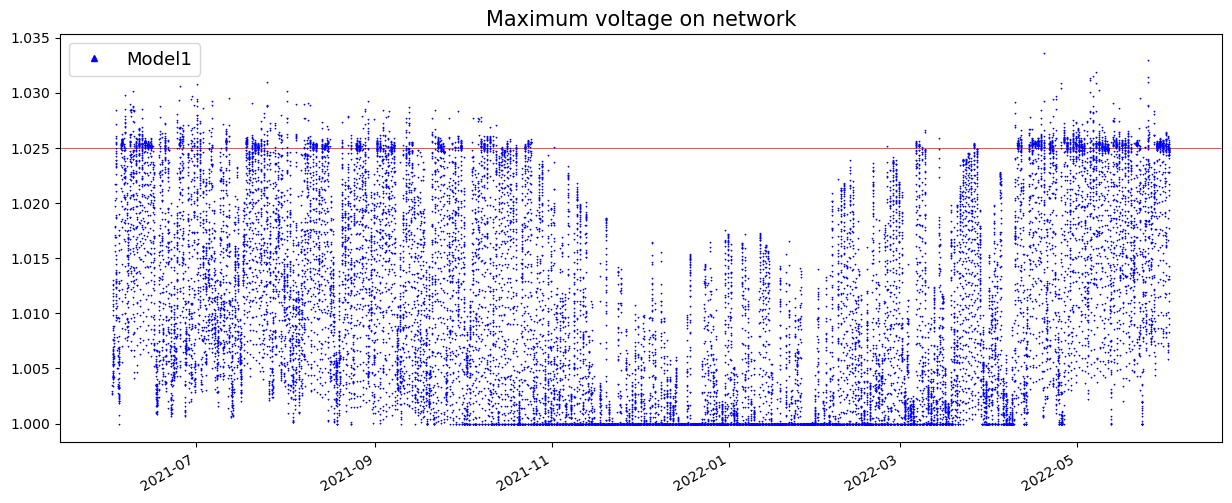

In [22]:
fig, axx = plt.subplots(figsize=(15,6), dpi=100)
plt.axhline(vm_mu_max,color='r', lw=0.5)

max_vm_pu_rnn_df.plot(style = ['b^'],markersize=0.5, ax=axx)
plt.legend( fontsize=13, markerscale=10)
plt.title("Maximum voltage on network", fontsize=15);

#### Show Energy

In [23]:
# Create new dataFrame based on the actual output of block Prod and rename it 
# following the model that has been used.
df_ctrldHvProd_rnn = ctrld_HvProd_opt.copy(deep=True)
df_ctrldHvProd_rnn.rename({ctrld_HvProd_name:'RNN_' + paramUser}, axis='columns')


# Concat created df and ctrld HV prod with no control
ctrld_hvProd_concat_df = pd.concat([df_final.loc[df_ctrldHvProd_rnn.index, [ctrld_HvProd_name]],
                             df_ctrldHvProd_rnn], axis='columns')

# # Rename
ctrld_hvProd_concat_df.rename(columns=({ctrld_HvProd_name:'No_Control'}), inplace=True);

# Compute Energy
var_no_control, var_rnn = ctrld_hvProd_concat_df.sum()*Δt

print(f'{ctrld_HvProd_name} prod, No Control : {var_no_control:.2f} MWh')
print(f'{ctrld_HvProd_name} prod, {paramUser}     : {var_rnn:.2f} MWh |  Perc = {var_rnn*100/var_no_control:.2f}%')


P0100 prod, No Control : 5060.71 MWh
P0100 prod, Model2     : 5060.71 MWh |  Perc = 100.00%


##### Save Variables
*<span style='color:green'>Run the following cell only one </span>*

In [27]:
var_to_save = dict({f'{ctrld_HvProd_name}_concat_df':ctrld_hvProd_concat_df.loc[mask_per2work],
                    'voltage_rise_df':max_vm_pu_rnn_df.loc[mask_per2work], 
                    'Out_blocProd': model1_pred_res.loc[mask_per2work]# Where out bloc prod is the result 
                                                                      # of the prediction using the RNN model 
                                                                      # and the corresponding OPF voltage rise
                   })

joblib.dump(var_to_save,f'{simResult_folder}RNN_pred_res_{paramUser}.pkl')
# Simulation with all others value of ``paramUser is done and saved 
# in ../Pickle_files/simulationResults/ under the name RNN_pred_res_Model'x' where x in {1,2,3} for model1,2,3 
# and for a combination of at least 1, 2 or all 3 models under the name  
# RNN_pred_res_AtLeast'x'Model where x in {1,2,3} 

['../Pickle_files/simulationResults/RNN_pred_res_Model1.pkl']